# Creating Party Vote Share Cartograms with pycartogram

This notebook demonstrates how to use `pycartogram` to create density-equalizing
cartograms from geographic data. We'll visualize the 2021 German federal election
(Bundestagswahl) results by creating cartograms where each electoral district
(Wahlkreis) is scaled according to the vote share of different political parties.

## What is a Cartogram?

A cartogram is a map where regions are distorted so their area becomes proportional
to a variable of interest. In this example, districts with higher vote shares for
a party will appear larger, while districts with lower vote shares will shrink.

## What we'll cover:
1. Loading geographic and election data
2. Preparing density values for cartogram generation
3. Creating cartograms with `GeoDataFrameWardCartogram`
4. Visualizing results with custom colormaps
5. Creating animated transitions between cartograms

## Imports

In [1]:
import numpy as np
import geopandas as gpd
import polars as pl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

from pycartogram.geopandas_cartogram import GeoDataFrameWardCartogram
from pycartogram.tools import fix_geodataframe_geometries
from shapely.geometry import Polygon, MultiPolygon

%matplotlib inline

## 1. Loading the Data

We need two datasets:
1. **Election statistics** - Vote shares for each party in each electoral district
2. **Geographic boundaries** - Polygon shapes of Germany's 299 electoral districts (Wahlkreise)

The election data contains "Zweitstimme" (second vote) percentages, which determine 
the proportional representation of parties in the Bundestag.

In [3]:
# Load election statistics
statsdata = pl.read_csv('data/btw21_stats.csv')
statsdata = statsdata.sort(by='wkr_nr')

# Load electoral district boundaries
gdf = gpd.read_file("data/Geometrie_Wahlkreise_20DBT_VG250.json")
gdf = gdf.set_crs('EPSG:25832', allow_override=True)

print(f"Loaded {len(gdf)} electoral districts")
print(f"CRS: {gdf.crs}")

Loaded 299 electoral districts
CRS: EPSG:25832


## 2. Setting Up Party Colors

Each German political party has an associated color. We'll create custom colormaps
that go from white (low vote share) to the party color (high vote share).

In [4]:
# Define parties and their official colors
PARTIES = ["CDU", "CSU", "SPD", "GRÜNE", "FDP", "DIE LINKE", "AfD"]
PARTY_COLORS = {
    "CDU": "#737373",       # Grey (CDU)
    "CSU": "#858590",       # Grey-blue (CSU, Bavaria only)
    "SPD": "#fb6a4a",       # Red (Social Democrats)
    "GRÜNE": "#74c476",     # Green (Greens)
    "FDP": "#fe9929",       # Yellow/Orange (Liberals)
    "DIE LINKE": "#f768a1", # Pink/Magenta (Left Party)
    "AfD": "#4eb3d3",       # Light Blue (AfD)
}

def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple (0-1 range)."""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255 for i in (0, 2, 4))

def rgb_to_hex(rgb):
    """Convert RGB tuple (0-1 range) to hex string."""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def create_party_colormap(party):
    """Create a colormap from white to party color."""
    party_rgb = hex_to_rgb(PARTY_COLORS[party])
    colors = [(1.0, 1.0, 1.0), party_rgb]  # white to party color
    return LinearSegmentedColormap.from_list(party, colors, N=256)

# Create colormaps for each party
cmaps = {party: create_party_colormap(party) for party in PARTIES}

## 3. Preparing the GeoDataFrame

To create a cartogram, we need to compute a **density** value for each region.
The cartogram algorithm will then distort the map so that areas with higher
density expand and areas with lower density shrink.

For vote share cartograms, the density is: `vote_share / geographic_area`

This means districts with the same vote share but different geographic sizes
will be scaled to have the same visual area in the cartogram.

In [5]:
# Handle missing values (CSU only runs in Bavaria, so other districts have null)
MIN_VAL = 0.5  # Small placeholder value for parties not running in a district
statsdata_clean = statsdata.clone()
for party in PARTIES:
    col = f"{party}_zweitstimme"
    if col in statsdata_clean.columns:
        statsdata_clean = statsdata_clean.with_columns(
            pl.col(col).cast(pl.Float64).fill_null(MIN_VAL)
        )
statsdata_pd = statsdata_clean.to_pandas()

# Calculate area of each district
gdf['area'] = gdf['geometry'].area

# Add party-specific columns to the GeoDataFrame
for party in PARTIES:
    col = f"{party}_zweitstimme"
    
    # Density = vote share / area (this is what drives the cartogram transformation)
    gdf[f"{party}_density"] = statsdata_pd[col] / gdf['area']
    
    # Store raw vote share for reference
    gdf[f"{party}_zweitstimme"] = statsdata_pd[col].values
    
    # Normalized values (0-1) for coloring
    val = gdf[f"{party}_zweitstimme"]
    normalized = (val - val.min()) / (val.max() - val.min())
    gdf[f"{party}_normalized"] = normalized
    
    # Pre-compute colors for each district
    gdf[f"{party}_color"] = [rgb_to_hex(cmaps[party](v)[:3]) for v in normalized]

print("Added density and color columns for each party")

Added density and color columns for each party


## 4. Defining the Plotting Function

We'll create a helper function to plot the GeoDataFrame with party colors
and state boundaries. This function will be used for both the original map
and the cartogram.

In [6]:
def plot_gdf(gdf, party, linewidth_wkr=0.3, linewidth_state=1.5, 
             figsize=(10, 10), edgecolor='#333333', show_title=True):
    """
    Plot a GeoDataFrame colored by party vote share.
    
    Parameters
    ----------
    gdf : GeoDataFrame
        The geographic data to plot (original or cartogram-transformed)
    party : str
        Party name (e.g., 'SPD', 'CDU')
    linewidth_wkr : float
        Line width for electoral district boundaries
    linewidth_state : float
        Line width for state (Bundesland) boundaries
    figsize : tuple
        Figure size in inches
    edgecolor : str
        Color for boundary lines
    show_title : bool
        Whether to show party name as title
    
    Returns
    -------
    ax : matplotlib Axes
    """
    colors = gdf[f"{party}_color"]
    
    plt.rcParams['figure.facecolor'] = '#f8f8f8'
    
    # Plot electoral districts
    ax = gdf.plot(color=colors, edgecolor=edgecolor, linewidth=linewidth_wkr, figsize=figsize)
    
    # Add state boundaries (dissolve districts by state, then plot outline)
    gdf_valid = fix_geodataframe_geometries(gdf)
    laender = gdf_valid.dissolve(by='LAND_NR').buffer(10)
    laender = laender.apply(
        lambda shape: Polygon(shape.exterior.coords) 
        if isinstance(shape, Polygon) 
        else max(shape.geoms, key=lambda a: a.area)
    )
    laender.plot(facecolor='None', edgecolor=edgecolor, ax=ax, lw=linewidth_state)
    
    # Handle islands (some districts are MultiPolygons)
    for island_idx, poly_idx in zip([8, 15], [1, 1]):
        if island_idx < len(gdf):
            multi = gdf['geometry'].iloc[island_idx]
            if isinstance(multi, MultiPolygon):
                geoms = list(multi.geoms)
                if len(geoms) > poly_idx:
                    gpd.GeoSeries(geoms[poly_idx]).plot(
                        facecolor='None', edgecolor=edgecolor, ax=ax, lw=linewidth_state
                    )
    
    ax.axis('off')
    
    if show_title:
        ax.get_figure().suptitle(
            party, color='#555555', fontsize=24,
            x=0.03, y=0.97, ha='left', va='top'
        )
    
    # Fixed axis limits for consistent framing
    ax.set_xlim(254554.69, 953002.50)
    ax.set_ylim(5198910.19, 6126105.33)
    ax.get_figure().tight_layout()
    
    plt.rcParams['figure.facecolor'] = '#ffffff'
    
    return ax

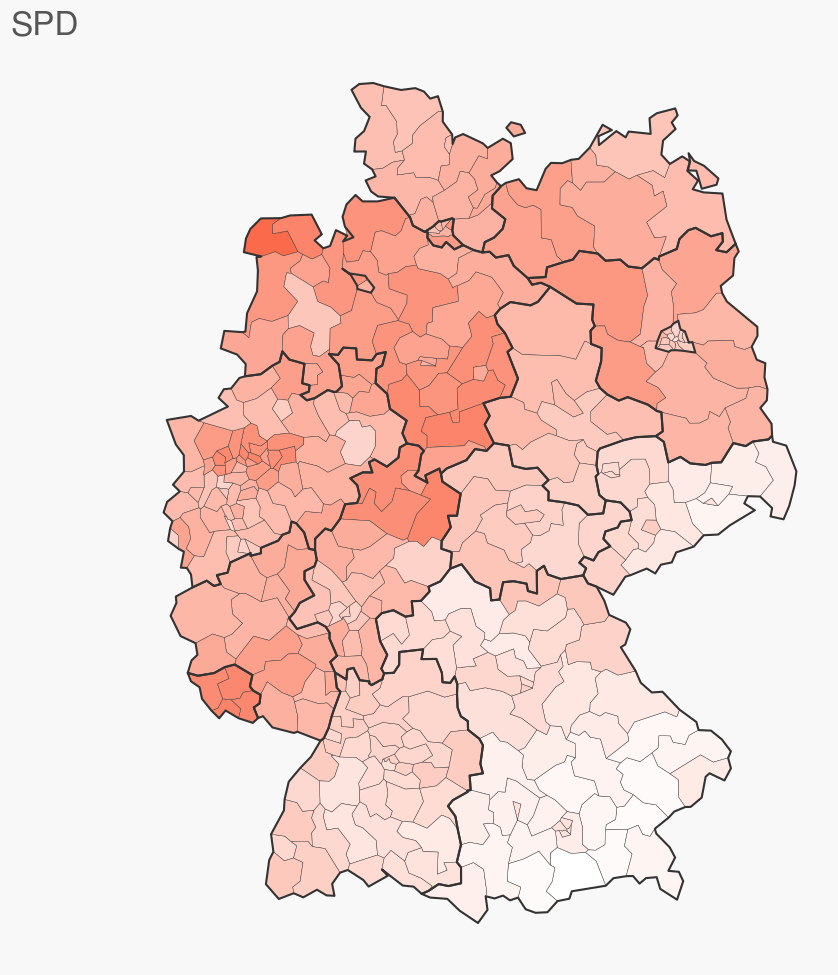

In [7]:
# Test the plotting function with the original (non-transformed) map
plot_gdf(gdf, "SPD");

## 5. Creating the Cartogram

Now we use `GeoDataFrameWardCartogram` to create the cartogram. The key steps are:

1. **Initialize** with the GeoDataFrame and density column name
2. **cast_density_to_matrix()** - Rasterize the density values onto a grid
3. **compute()** - Run the cartogram algorithm to compute the transformation
4. **get_cartogram_geo_df()** - Get the transformed GeoDataFrame

The algorithm iteratively diffuses the density field while deforming the polygon
boundaries, eventually producing a map where each region's area is proportional
to its density value.

In [8]:
def create_party_cartogram(gdf, party):
    """
    Create a cartogram for a specific party's vote share.
    
    Parameters
    ----------
    gdf : GeoDataFrame
        The geographic data with density columns
    party : str
        Party name
    
    Returns
    -------
    carto : GeoDataFrameWardCartogram
        The cartogram object (stores both original and transformed geometries)
    """
    density_col = f"{party}_density"
    
    # Initialize the cartogram
    # - y_raster_size/x_raster_size: Resolution of the density grid
    # - map_orientation: 'portrait' for Germany (taller than wide)
    carto = GeoDataFrameWardCartogram(
        gdf,
        density_col,
        y_raster_size=2048,
        x_raster_size=768 * 2,
        map_orientation='portrait'
    )
    
    # Rasterize density to a grid
    # set_boundary_to: Value for areas outside all polygons
    carto.cast_density_to_matrix(verbose=True, set_boundary_to='mean')
    
    # Compute the cartogram transformation
    carto.compute(verbose=True)
    
    return carto

In [9]:
# Create cartograms for all parties (this takes a few minutes)
cartograms = {}
for party in PARTIES:
    print(f"\n{'='*50}")
    print(f"Creating cartogram for {party}...")
    print('='*50)
    cartograms[party] = create_party_cartogram(gdf, party)


Creating cartogram for CDU...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 33.23it/s]
    2%  |=                  


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:07<00:00,  4.51it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



Creating cartogram for CSU...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.44it/s]
  100%  |==================================================|



computing cartogram...


transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.44it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 4 invalid (self-intersecting) polygon(s) at indices: [17, 118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



Creating cartogram for SPD...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.31it/s]
    2%  |=      


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:09<00:00,  4.35it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



Creating cartogram for GRÜNE...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.10it/s]
    2%  |=                          


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:09<00:00,  4.35it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 4 invalid (self-intersecting) polygon(s) at indices: [82, 118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



Creating cartogram for FDP...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.01it/s]
    2%  |=                         


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:09<00:00,  4.40it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 4 invalid (self-intersecting) polygon(s) at indices: [82, 118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



Creating cartogram for DIE LINKE...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.17it/s]
    2%  |=                


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.45it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 3 invalid (self-intersecting) polygon(s) at indices: [118, 247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(



Creating cartogram for AfD...


cast density to matrix: 100%|████████████████████████████████████████████████████████████████| 304/304 [00:09<00:00, 32.54it/s]
   59%  |=============================                     |


computing cartogram...


  100%  |==================================================|
transforming wards: 100%|████████████████████████████████████████████████████████████████████| 304/304 [01:08<00:00,  4.43it/s]
/Users/bfmaier/Dropbox/independent-python-packages/pycartogram/pycartogram/ward_cartogram.py:729: UserWarning: Cartogram produced 2 invalid (self-intersecting) polygon(s) at indices: [247, 256]. This typically occurs when there aren't enough vertices to represent the deformation. Consider enriching the original geometries with more points. To fix invalid geometries before operations like dissolve(), use pycartogram.tools.fix_invalid_geometry() for single polygons or pycartogram.tools.fix_geodataframe_geometries() for GeoDataFrames.
  warnings.warn(


## 6. Visualizing the Results

Now let's plot all the party cartograms. Notice how:
- **Urban areas** (higher population density, more voters) expand
- **Rural areas** (lower population density) shrink
- Districts with higher vote share for each party appear larger

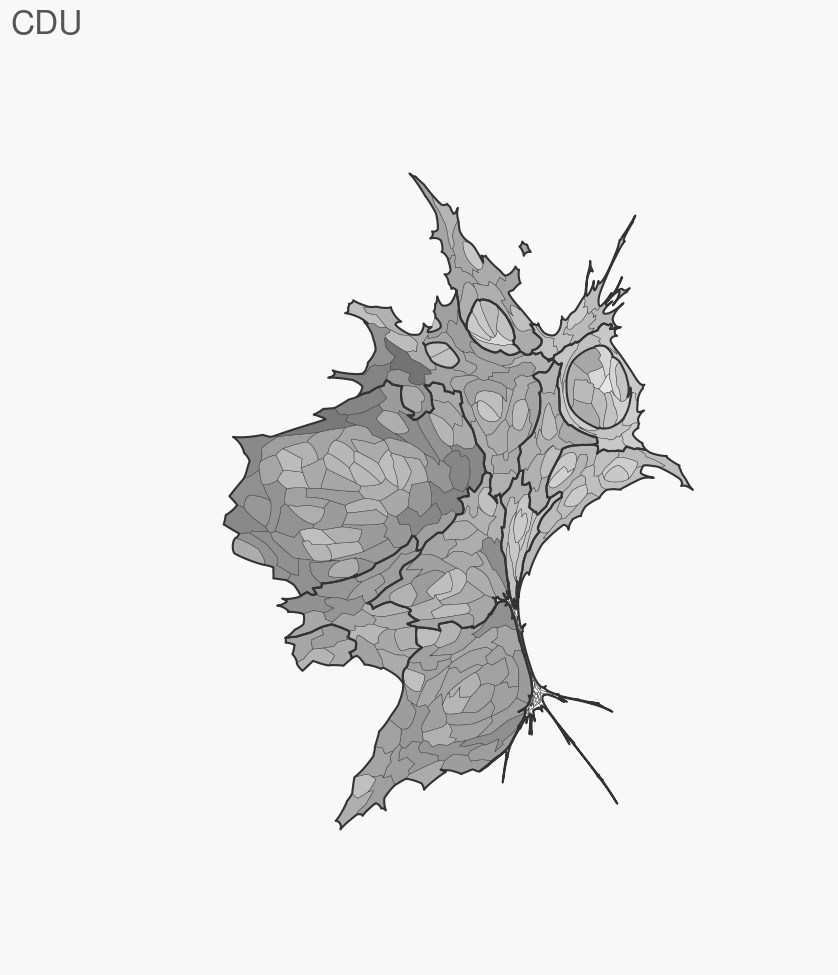

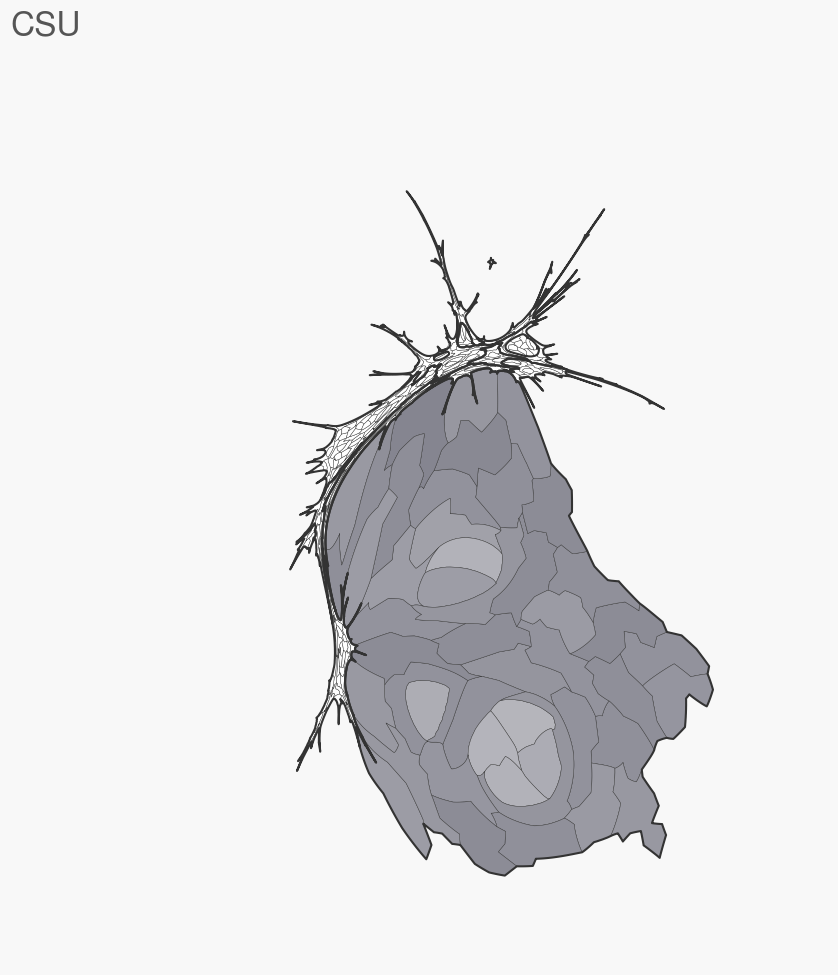

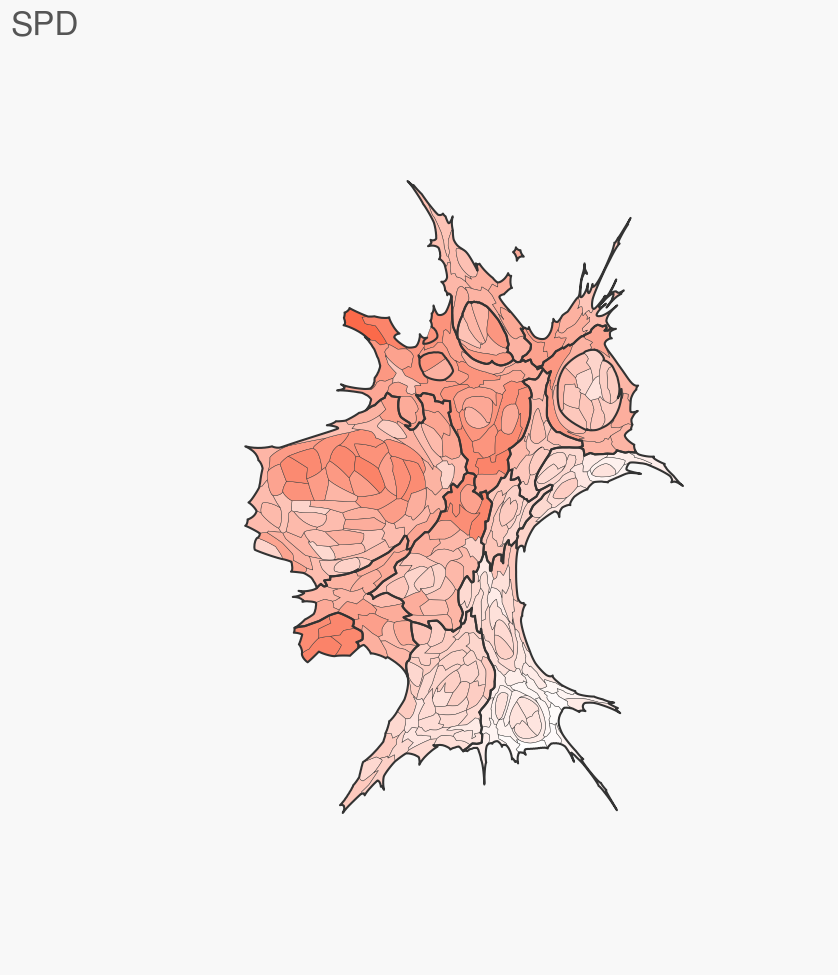

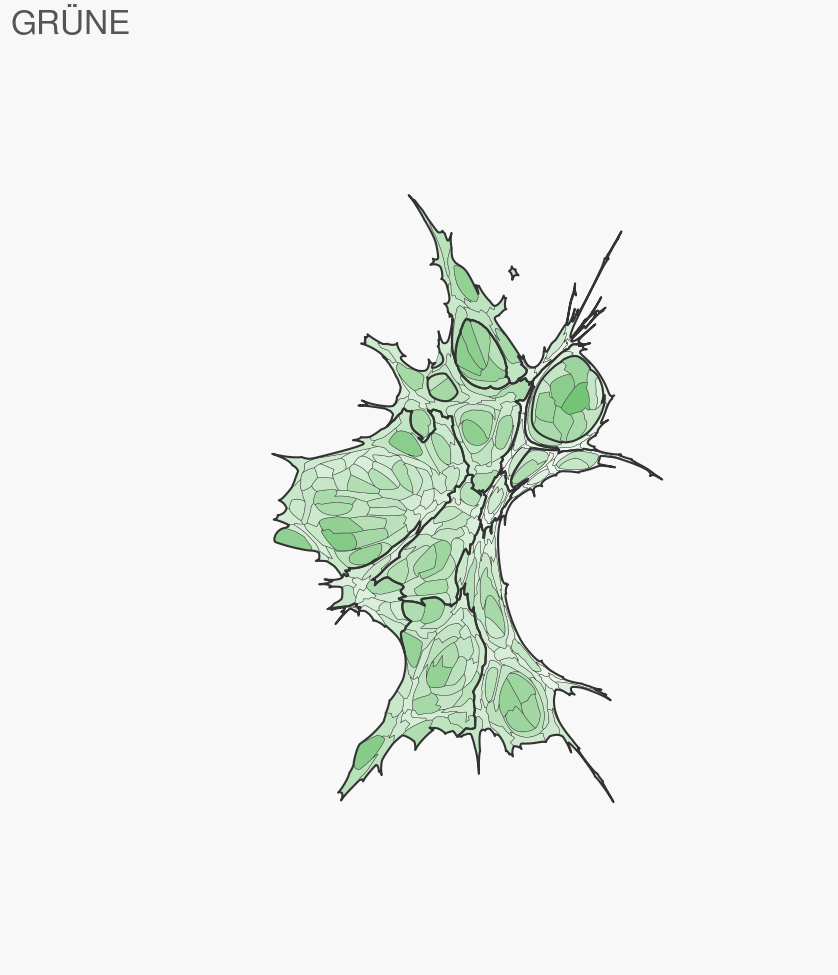

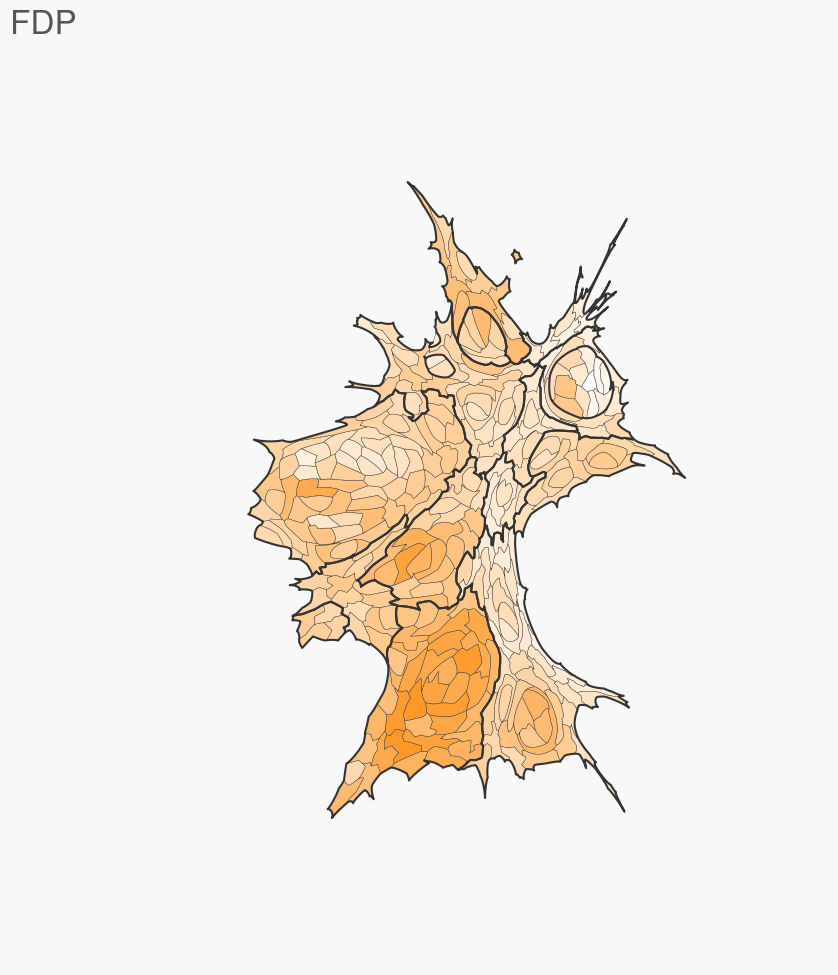

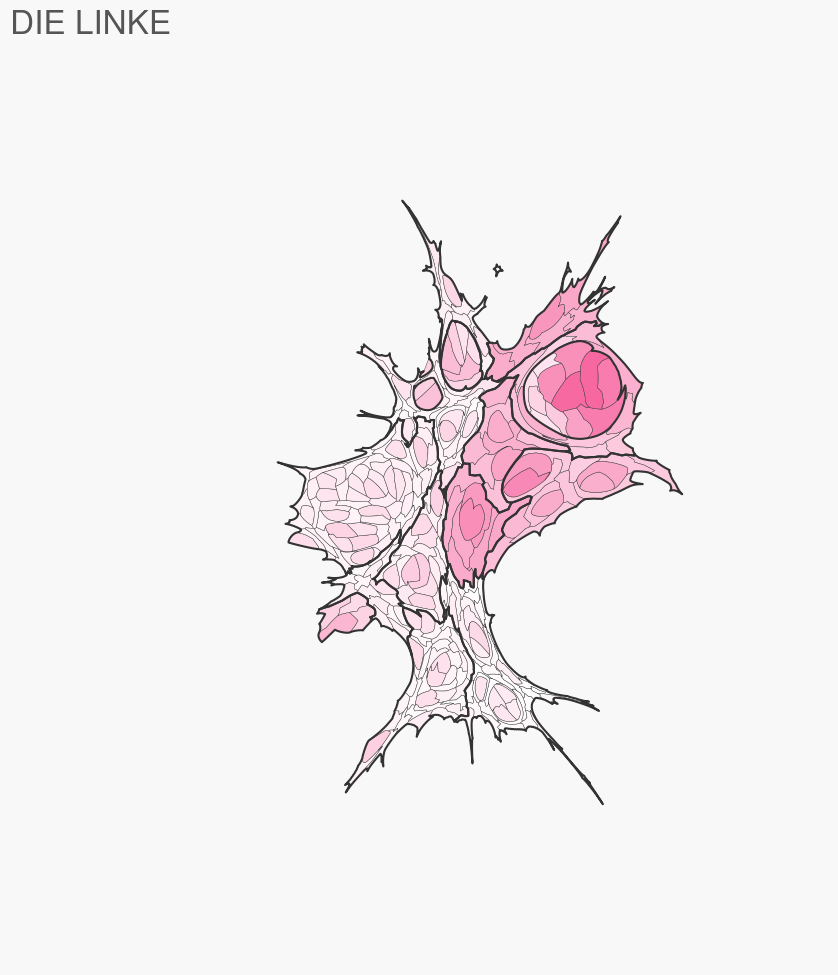

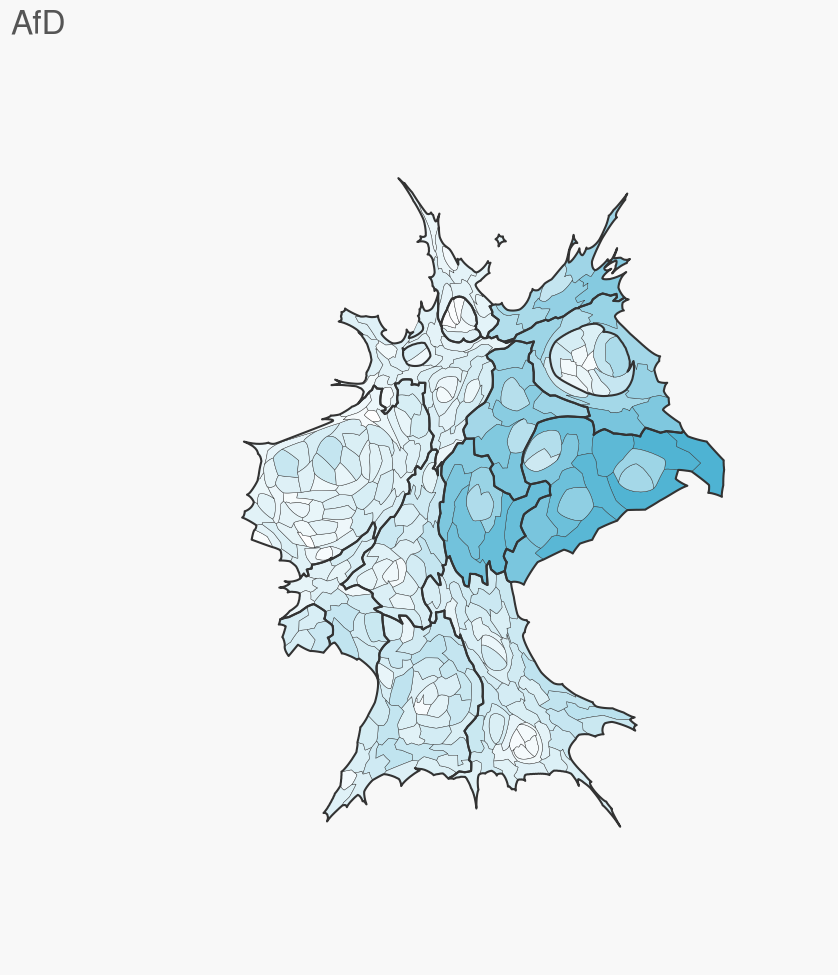

In [10]:
# Plot all party cartograms
for party in PARTIES:
    carto = cartograms[party]
    # Get the transformed GeoDataFrame
    gdf_carto = carto.get_cartogram_geo_df()
    plot_gdf(gdf_carto, party)
    plt.show()

## 7. Animated Transitions (Bonus)

The cartogram object can also generate **interpolated** geometries between
the original map and the cartogram. This is useful for creating smooth
animations that help viewers understand how the map transforms.

The `get_interpolated_geo_df(t)` method returns a GeoDataFrame where `t=0`
is the original map and `t=1` is the fully transformed cartogram.

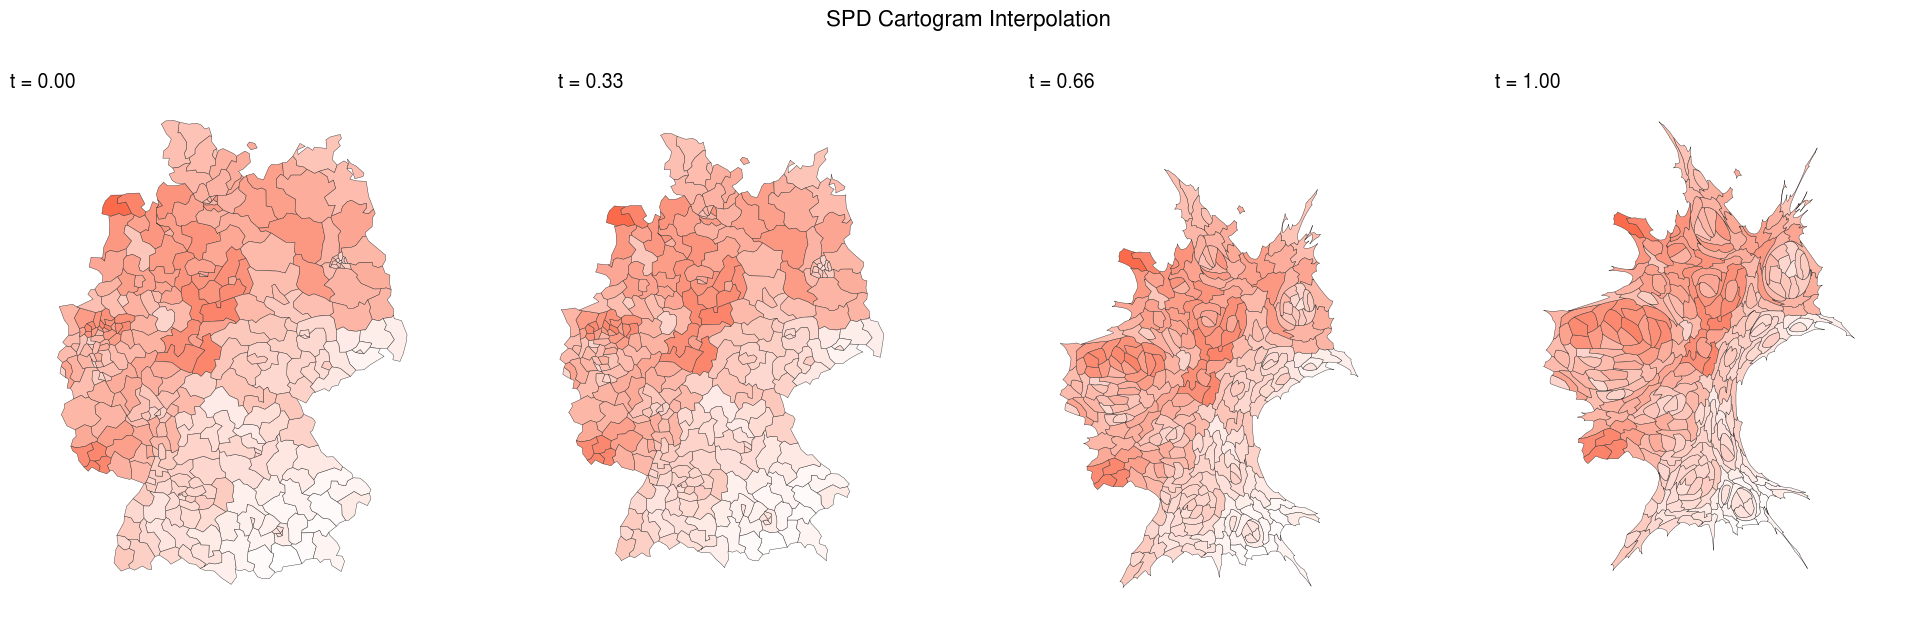

In [11]:
# Show interpolation at different stages
party = "SPD"
carto = cartograms[party]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, t in enumerate([0.0, 0.33, 0.66, 1.0]):
    ax = axes[i]
    
    # Get interpolated geometry
    gdf_interp = carto.get_interpolated_geo_df(t)
    
    # Plot
    gdf_interp.plot(
        color=gdf_interp[f"{party}_color"],
        edgecolor='#333333',
        linewidth=0.3,
        ax=ax
    )
    ax.axis('off')
    ax.set_title(f"t = {t:.2f}", fontsize=14)

fig.suptitle(f"{party} Cartogram Interpolation", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we demonstrated how to use `pycartogram` to:

1. **Load and prepare data** - Combine geographic boundaries with statistical data
2. **Compute densities** - Calculate the density values that drive the cartogram transformation
3. **Create cartograms** - Use `GeoDataFrameWardCartogram` to transform the map
4. **Visualize results** - Plot both original and transformed maps
5. **Create animations** - Use interpolation for smooth transitions

Key classes and methods:
- `GeoDataFrameWardCartogram(gdf, density_column, ...)` - Main cartogram class
- `cast_density_to_matrix()` - Rasterize densities
- `compute()` - Run the transformation algorithm
- `get_cartogram_geo_df()` - Get transformed geometries
- `get_interpolated_geo_df(t)` - Get interpolated geometries for animation